In [1]:
import collections
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import random
import time
import copy

import ipynbname
#notebook_name = ipynbname.name()
notebook_name = 'f0-50-LL'

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from local_utils import *

In [2]:
from sklearn.preprocessing import MinMaxScaler
WINDOW_SIZE = 48
STEP_SIZE = 1

# Assuming split and scale functions are defined elsewhere

# Load and prepare data
file_name = 'clusterf0.csv'  # File to be read
file_path = f'/home/verxus/diplo/DATA/clusters/{file_name}'  # File location

df = pd.read_csv(file_path)
df['DHH'] = pd.to_datetime(df['DHH'])
df['kW/h'] = df['kW/h'].astype(np.float32)

In [3]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input((WINDOW_SIZE,1)),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32),
        tf.keras.layers.Dense(32),
        tf.keras.layers.Dense(1)
    ])
    return model

early_stopping = EarlyStopping(
    monitor='loss',  # Metric to monitor (e.g., validation loss)
    patience=6,         # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restores the model weights from the epoch with the best performance
)

In [4]:
def process_and_train_for_client(client_id, df):
    tar_df = df[df['POD'] == client_id]
    
    train_data, test_data, scaler = train_test_split_and_scale(tar_df)

    # Create windows for training and testing
    X, Y = create_sliding_window(train_data, WINDOW_SIZE, STEP_SIZE)
    Xtest, Ytest = create_sliding_window(test_data, WINDOW_SIZE, STEP_SIZE)
    # Align datetime values

    loss = tf.keras.losses.MeanSquaredError()
    
    metrics = [
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]

    # Define and compile model
    model = create_model()
    model.compile(loss=loss,
                  optimizer=Adam(learning_rate=0.001),
                  metrics=metrics)

    # Train model
    model.fit(X, Y, epochs=5, callbacks=[early_stopping])

    # Evaluation
    test_loss, test_mae, test_rmse, = model.evaluate(Xtest, Ytest)
    train_loss, train_mae, train_rmse = model.evaluate(X, Y)

    # Predictions
    predictions = model.predict(Xtest)
    aligned_datetimes = align_datetime_with_predictions(test_data, predictions, WINDOW_SIZE, STEP_SIZE)

    # Unscaling
    actual_values = np.array(Ytest).reshape(-1, 1)
    predicted_values = predictions.reshape(-1, 1)
    actual_values_uns = scaler.inverse_transform(actual_values)
    predicted_values_uns = scaler.inverse_transform(predicted_values)

    plot_predictions(actual_values_uns, predicted_values_uns, client_id, aligned_datetimes)

    print(f"Client: {client_id}, Train Loss: {train_loss}, Train MAE: {train_mae}, Train RMSE: {train_rmse}, Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")
    
    return train_loss, train_mae, train_rmse, test_loss, test_mae, test_rmse

    # Ensure you define `split`, `create_window_for_timeseries`, and `build_model` functions appropriately

Epoch 1/50
1823/1823 [==============================] - 8s 4ms/step - loss: 0.0012 - mean_absolute_error: 0.0198 - root_mean_squared_error: 0.0345
Epoch 2/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.0010 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0321
Epoch 3/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.0010 - mean_absolute_error: 0.0176 - root_mean_squared_error: 0.0318
Epoch 4/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.0010 - mean_absolute_error: 0.0177 - root_mean_squared_error: 0.0317
Epoch 5/50
1823/1823 [==============================] - 7s 4ms/step - loss: 9.8833e-04 - mean_absolute_error: 0.0173 - root_mean_squared_error: 0.0314
Epoch 6/50
1823/1823 [==============================] - 7s 4ms/step - loss: 9.7696e-04 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0313
Epoch 7/50
1823/1823 [==============================] - 7s 4ms/step - loss: 9.7715e-04 - mean_absolute_error: 

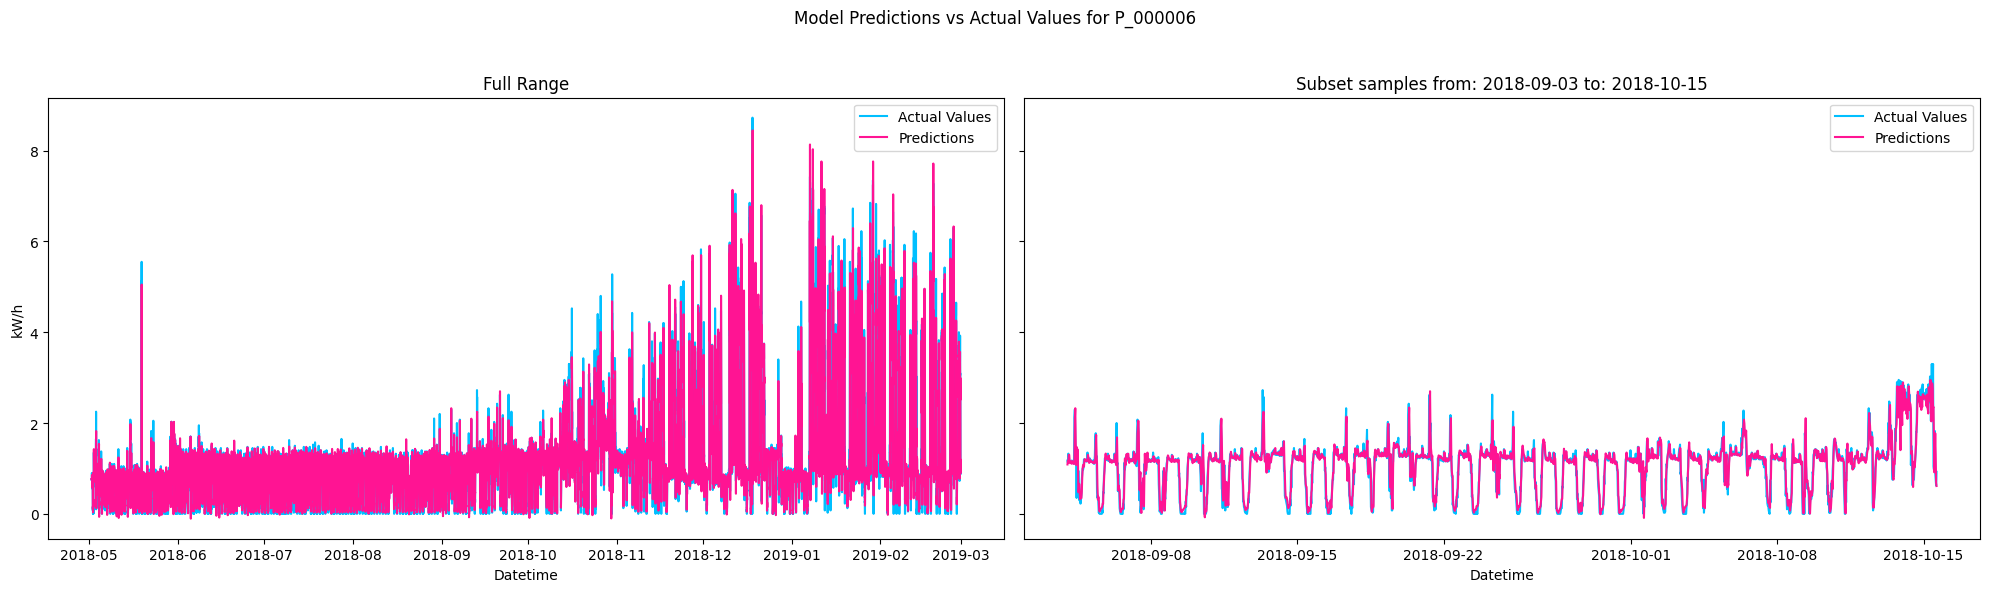

Client: P_000006, Train Loss: 0.0007397830486297607, Train MAE: 0.014957327395677567, Train RMSE: 0.027198953554034233, Test Loss: 0.0013472464634105563, Test MAE: 0.018015606328845024, Test RMSE: 0.036704856902360916
Epoch 1/50
1823/1823 [==============================] - 8s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0210 - root_mean_squared_error: 0.0443
Epoch 2/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0201 - root_mean_squared_error: 0.0431
Epoch 3/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0199 - root_mean_squared_error: 0.0427
Epoch 4/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0198 - root_mean_squared_error: 0.0423
Epoch 5/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0196 - root_mean_squared_error: 0.0421
Epoch 6/50
1823/1823 [=========================

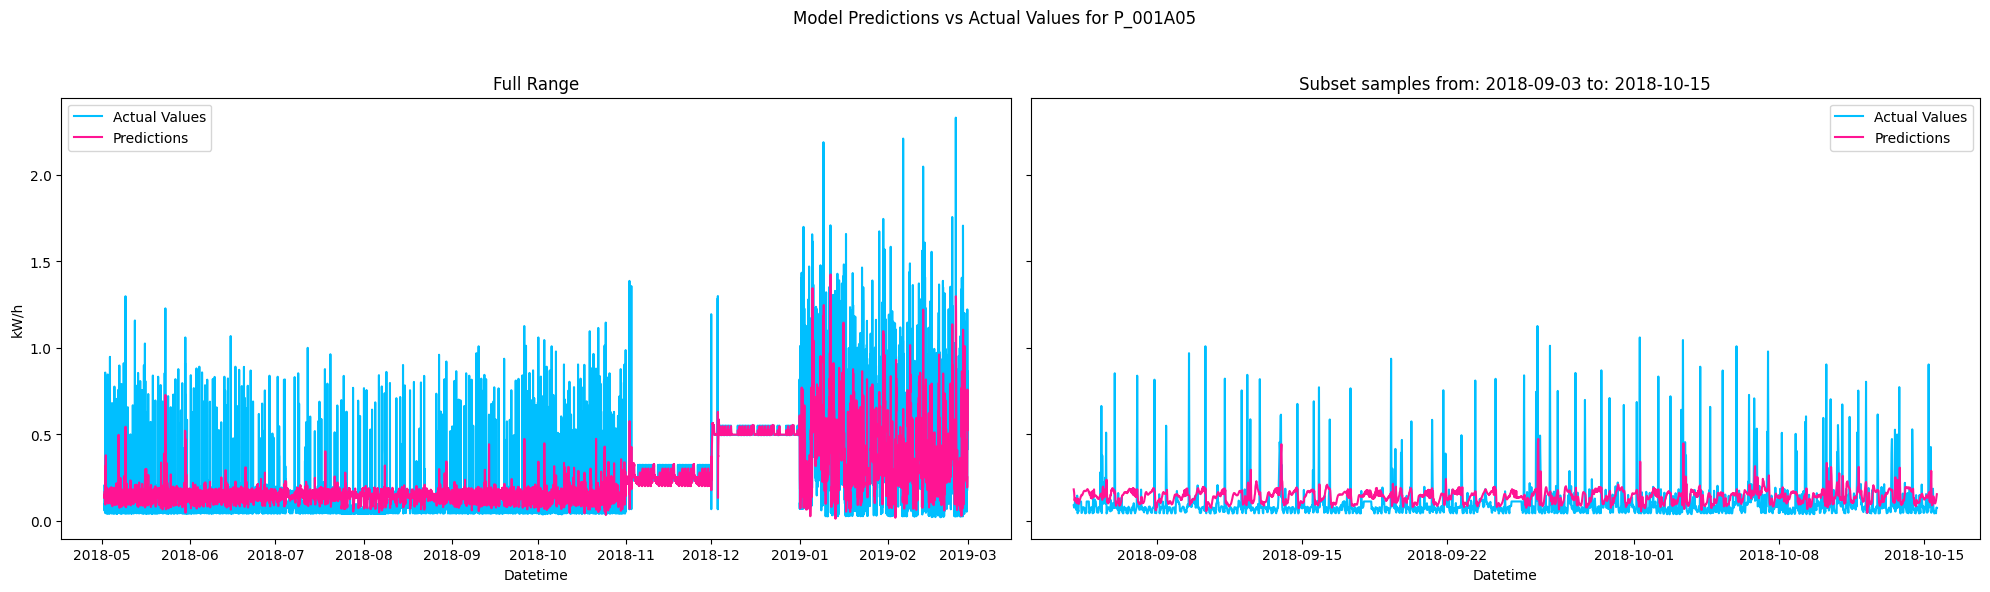

Client: P_001A05, Train Loss: 0.0014963584253564477, Train MAE: 0.012092048302292824, Train RMSE: 0.03868279233574867, Test Loss: 0.006462717428803444, Test MAE: 0.044103432446718216, Test RMSE: 0.08039102703332901
Epoch 1/50
1823/1823 [==============================] - 8s 4ms/step - loss: 9.5546e-04 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0309
Epoch 2/50
1823/1823 [==============================] - 7s 4ms/step - loss: 6.1463e-04 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0248
Epoch 3/50
1823/1823 [==============================] - 7s 4ms/step - loss: 5.8503e-04 - mean_absolute_error: 0.0111 - root_mean_squared_error: 0.0242
Epoch 4/50
1823/1823 [==============================] - 7s 4ms/step - loss: 5.6512e-04 - mean_absolute_error: 0.0108 - root_mean_squared_error: 0.0238
Epoch 5/50
1823/1823 [==============================] - 7s 4ms/step - loss: 5.5541e-04 - mean_absolute_error: 0.0106 - root_mean_squared_error: 0.0236
Epoch 6/50
1823/1823 [========

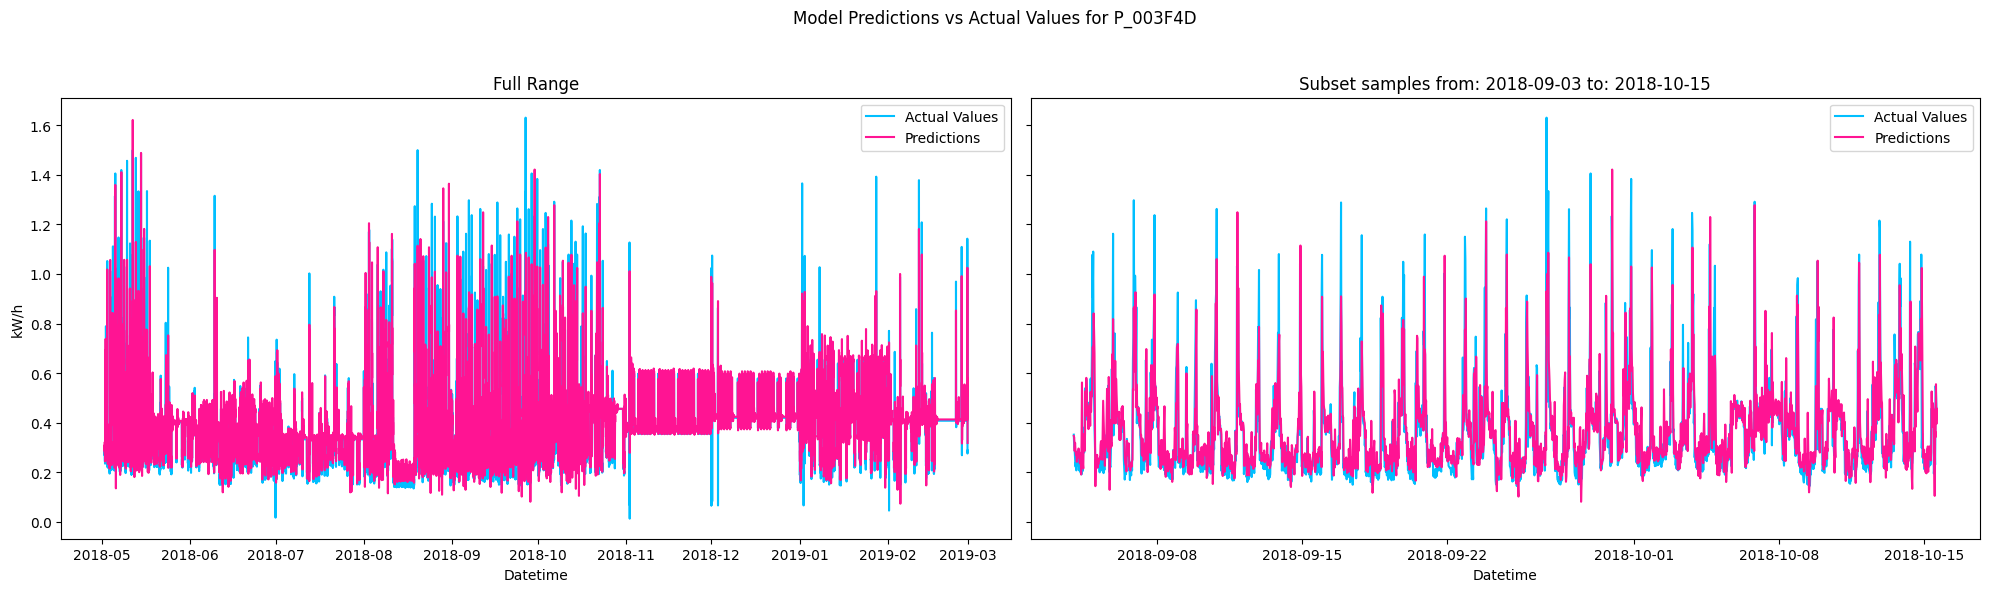

Client: P_003F4D, Train Loss: 0.00019522730144672096, Train MAE: 0.004150218330323696, Train RMSE: 0.013972376473248005, Test Loss: 0.0025176326744258404, Test MAE: 0.024419138208031654, Test RMSE: 0.05017601698637009
Epoch 1/50
1823/1823 [==============================] - 8s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0192 - root_mean_squared_error: 0.0441
Epoch 2/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0176 - root_mean_squared_error: 0.0408
Epoch 3/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0171 - root_mean_squared_error: 0.0405
Epoch 4/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0406
Epoch 5/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0403
Epoch 6/50
1823/1823 [=========================

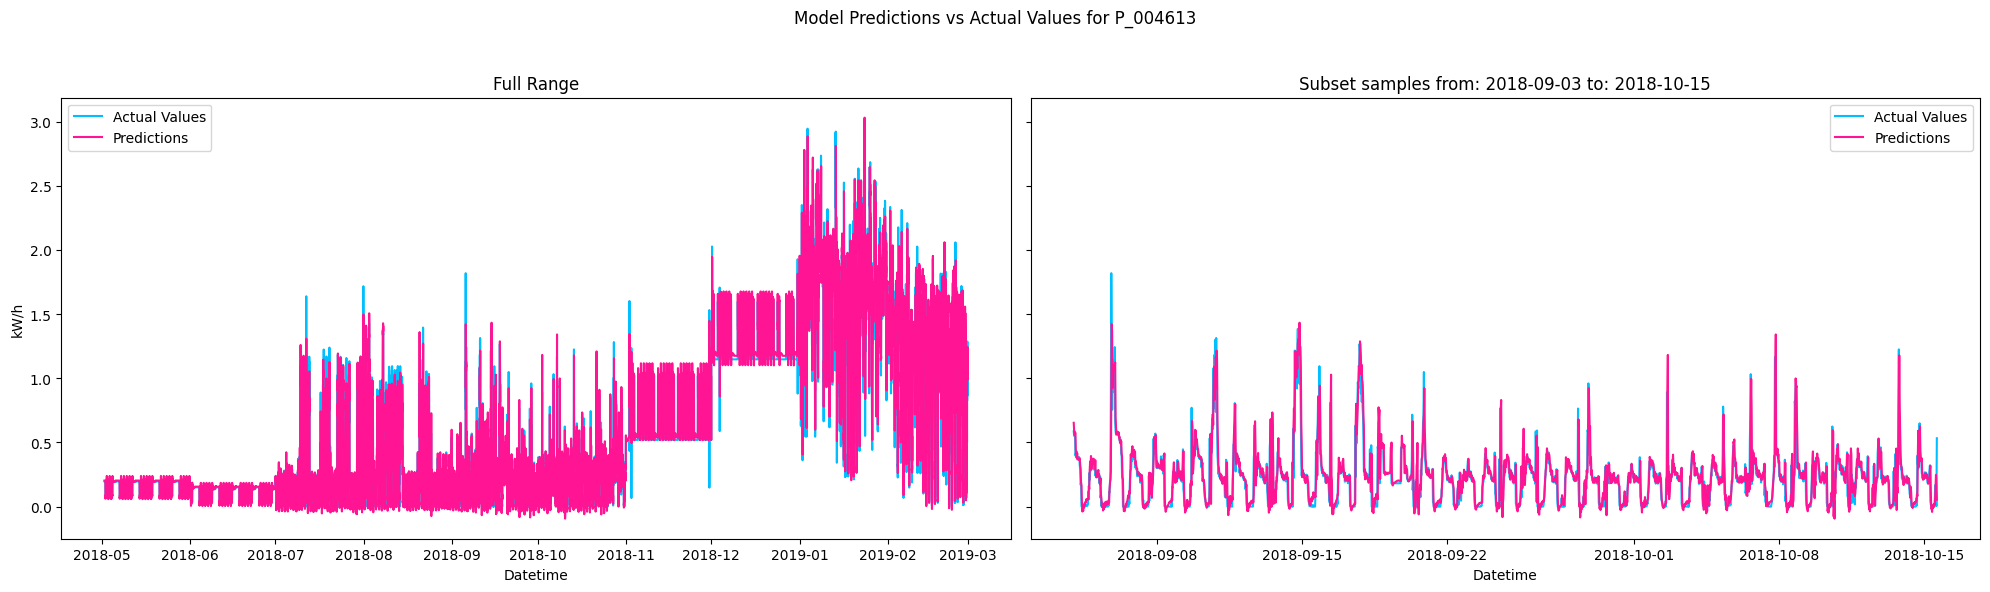

Client: P_004613, Train Loss: 0.001206822693347931, Train MAE: 0.011569994501769543, Train RMSE: 0.03473935276269913, Test Loss: 0.0018342080293223262, Test MAE: 0.022325973957777023, Test RMSE: 0.042827654629945755
Epoch 1/50
1823/1823 [==============================] - 8s 4ms/step - loss: 0.0042 - mean_absolute_error: 0.0412 - root_mean_squared_error: 0.0651
Epoch 2/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.0024 - mean_absolute_error: 0.0239 - root_mean_squared_error: 0.0485
Epoch 3/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.0023 - mean_absolute_error: 0.0235 - root_mean_squared_error: 0.0482
Epoch 4/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.0023 - mean_absolute_error: 0.0231 - root_mean_squared_error: 0.0478
Epoch 5/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.0022 - mean_absolute_error: 0.0225 - root_mean_squared_error: 0.0473
Epoch 6/50
1823/1823 [===========================

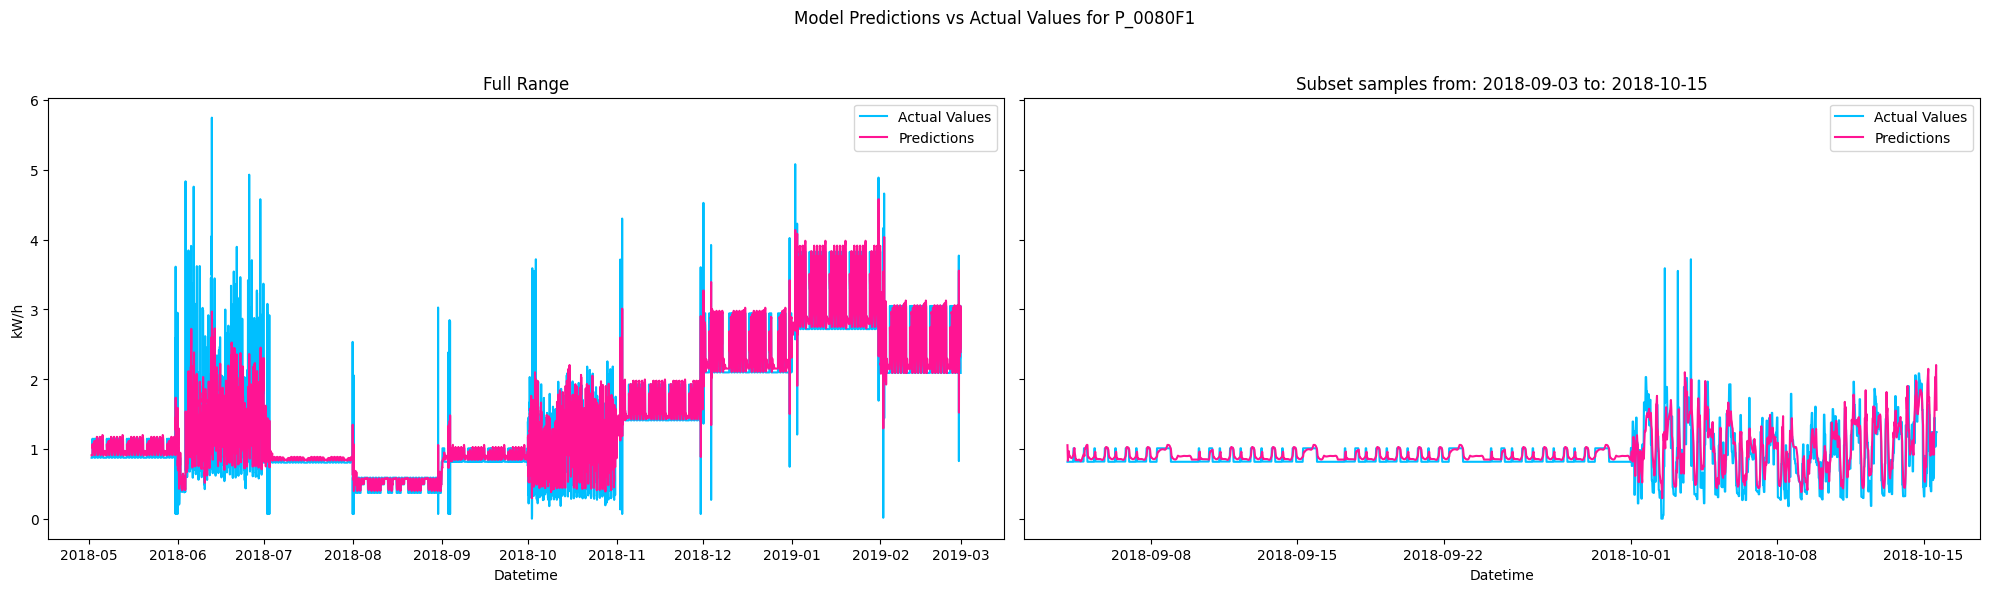

Client: P_0080F1, Train Loss: 0.0013944519450888038, Train MAE: 0.013132359832525253, Train RMSE: 0.037342362105846405, Test Loss: 0.0014127598842605948, Test MAE: 0.01809362880885601, Test RMSE: 0.037586696445941925
Epoch 1/50
1823/1823 [==============================] - 8s 4ms/step - loss: 0.0043 - mean_absolute_error: 0.0367 - root_mean_squared_error: 0.0658
Epoch 2/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.0035 - mean_absolute_error: 0.0320 - root_mean_squared_error: 0.0589
Epoch 3/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.0034 - mean_absolute_error: 0.0315 - root_mean_squared_error: 0.0583
Epoch 4/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.0033 - mean_absolute_error: 0.0309 - root_mean_squared_error: 0.0578
Epoch 5/50
1823/1823 [==============================] - 7s 4ms/step - loss: 0.0033 - mean_absolute_error: 0.0308 - root_mean_squared_error: 0.0572
Epoch 6/50
1823/1823 [==========================

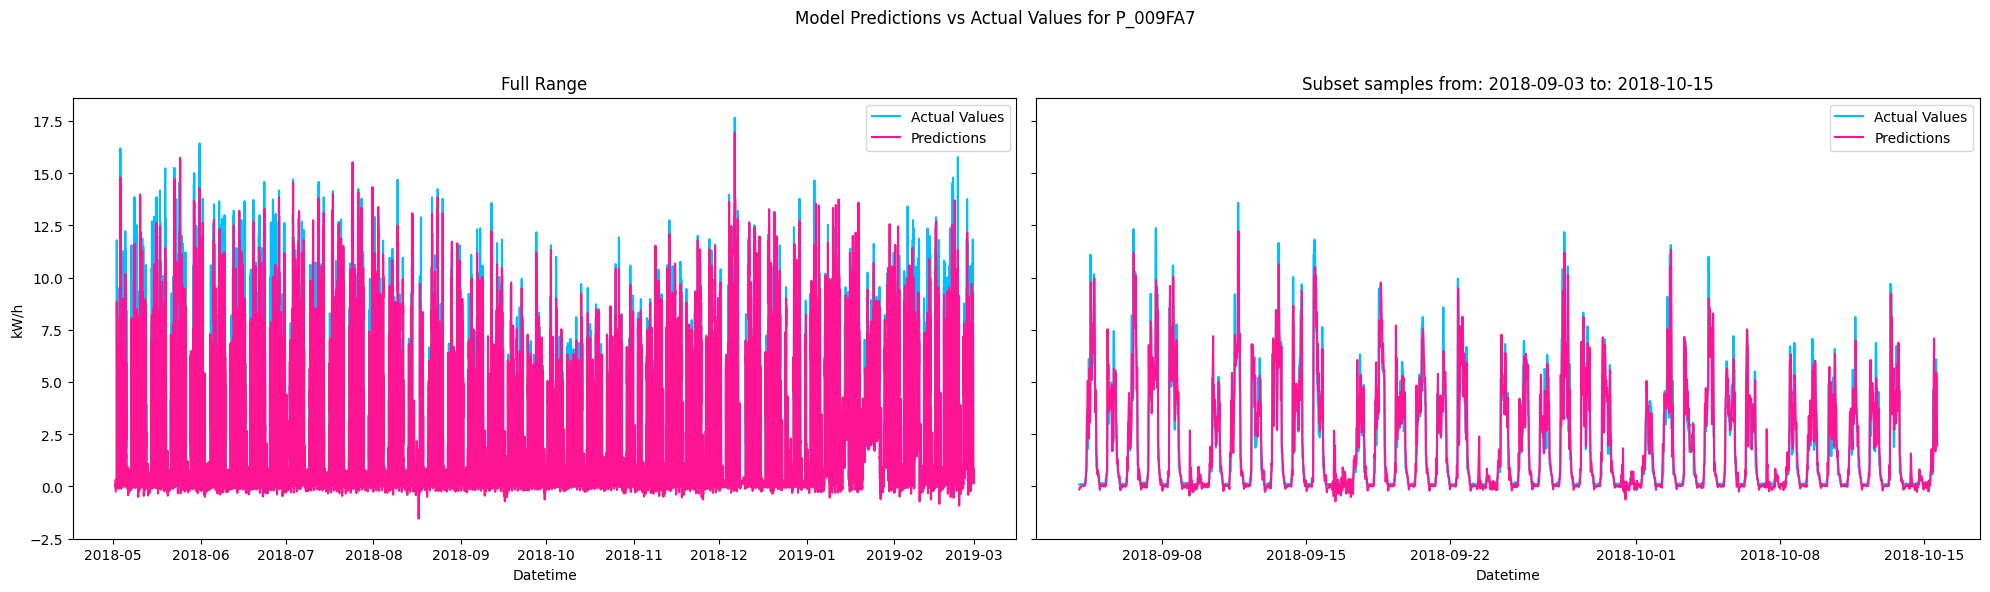

Client: P_009FA7, Train Loss: 0.0016980520449578762, Train MAE: 0.016393620520830154, Train RMSE: 0.04120742529630661, Test Loss: 0.006629812531173229, Test MAE: 0.04165659472346306, Test RMSE: 0.08142366260290146
Metrics summary saved to: /home/verxus/diplo/results/publication/LL/L-50-f0-LL_metrics.csv
     Train Loss Train MAE Train RMSE Test Loss Test MAE Test RMSE
Min      0.0002   0.00415    0.01397   0.00135  0.01802    0.0367
Max      0.0017   0.01639    0.04121   0.00663   0.0441   0.08142
Mean    0.00112   0.01205    0.03219   0.00337   0.0281   0.05485
       Metric  Min Value Min Client  Max Value Max Client  Mean Value
0  Train Loss    0.00020   P_003F4D    0.00170   P_009FA7    0.001123
1   Train MAE    0.00415   P_003F4D    0.01639   P_009FA7    0.012048
2  Train RMSE    0.01397   P_003F4D    0.04121   P_009FA7    0.032190
3   Test Loss    0.00135   P_000006    0.00663   P_009FA7    0.003367
4    Test MAE    0.01802   P_000006    0.04410   P_001A05    0.028103
5   Test RM

In [5]:
import pandas as pd

metrics_df = pd.DataFrame(columns=['Client', 'Train Loss', 'Train MAE', 'Train RMSE', 'Test Loss', 'Test MAE', 'Test RMSE'])

# Iterate over all clients and process/train
for client_id in df['POD'].unique():
    train_loss, train_mae, train_rmse, test_loss, test_mae, test_rmse = process_and_train_for_client(client_id, df)
    metrics_df = metrics_df.append({'Client': client_id, 
                                'Train Loss': round(train_loss, 5), 
                                'Train MAE': round(train_mae, 5), 
                                'Train RMSE': round(train_rmse, 5),
                                'Test Loss': round(test_loss, 5), 
                                'Test MAE': round(test_mae, 5),
                                'Test RMSE': round(test_rmse, 5)}, 
                                ignore_index=True)


compute_basic_metrics_and_save(metrics_df, notebook_name)
client_stats = compute_metrics_statistics_with_client(metrics_df)
print(client_stats)

In [11]:
#print('\n problems: 0091D7, 00B211, 007209, 003F4D')


 problems: 0091D7, 00B211, 007209, 003F4D
